In [1]:
import tqdm
import json
import pandas as pd
import requests

SHEET_ID = '1b6h2RApBs2xbN6-eGVvxH68EALKDklvS91fb7d_IVz4'
SHEET_TABS = {
    'REGISTROS': 2103959160,
    'USUARIOS': 102021014,
}
REGISTROS_URL = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv&gid={SHEET_TABS["REGISTROS"]}'
USUARIOS_URL = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv&gid={SHEET_TABS["USUARIOS"]}'

In [2]:
# Empezamos cargando todos los datos (los usuarios y los mapas estan en dos tablas distintas)
df_registros = pd.read_csv(REGISTROS_URL)
df_registros.drop("Timestamp", axis=1, inplace=True)
df_registros.dropna(inplace=True, how="any")
display(df_registros.sample(5))

df_usuarios = pd.read_csv(USUARIOS_URL)
df_usuarios.drop("Timestamp", axis=1, inplace=True)
df_usuarios.dropna(inplace=True, how="all")
display(df_usuarios.sample(5))

# Mergeamos!
df_mergeado = df_usuarios.merge(df_registros)
display(df_mergeado.sample(5))

,Padron,Carrera,Mapa
2104,102291,informatica,"{""materias"":[{""id"":""CBC"",""nota"":0},{""id"":""62.0..."
700,96335,industrial,"{""materias"":[{""id"":""CBC"",""nota"":0},{""id"":""81.0..."
3516,104354,informatica,"{""materias"":[{""id"":""CBC"",""nota"":0,""cuatri"":-1}..."
2391,102308,industrial,"{""materias"":[{""id"":""CBC24"",""nota"":10},{""id"":""C..."
212,99233,industrial,"{""materias"":[{""id"":""CBC24"",""nota"":7},{""id"":""CB..."


,Padron,Carrera,Orientacion,Final de Carrera
5336,105329,electronica,NaN,NaN
8105,93118,informatica,Sistemas de Producción,tpp
392,102758,sistemas,NaN,NaN
3600,94637,civil,NaN,NaN
4939,100299,petroleo,NaN,NaN


,Padron,Carrera,Orientacion,Final de Carrera,Mapa
3812,99148,agrimensura,NaN,tpp,"{""materias"":[{""id"":""CBC"",""nota"":0},{""id"":""62.0..."
3475,99966,industrial,NaN,tpp,"{""materias"":[{""id"":""CBC"",""nota"":0},{""id"":""81.0..."
3873,102824,civil,NaN,NaN,"{""materias"":[{""id"":""CBC"",""nota"":6,""cuatri"":-1}..."
4310,188383,sistemas,NaN,NaN,"{""materias"":[{""id"":""CBC"",""nota"":0}]}"
3828,106786,quimica,NaN,NaN,"{""materias"":[{""id"":""CBC"",""nota"":0,""cuatri"":-1}]}"


In [3]:
# Chequeemos con cuantos usuarios vamos a laburar...
df_mergeado.describe()

,Padron,Carrera,Orientacion,Final de Carrera,Mapa
count,4332,4332,649,1612,4332
unique,3629,15,5,2,3649
top,104915,industrial,Sistemas Distribuidos,tpp,"{""materias"":[{""id"":""CBC"",""nota"":0,""cuatri"":-1}..."
freq,13,1144,275,1270,159


In [4]:
### Testing purposes: en vez de laburar con toooodos los datos, laburemos solo con sistemas+informatica
# Comenta esta linea para que todo ande muchísimo más lento
df_mergeado = df_mergeado[(df_mergeado['Carrera'] == 'informatica') | (df_mergeado['Carrera'] == 'sistemas')]

In [5]:
# Ahora, desempaquetamos la columna "Mapa" (un JSON que contiene notas, metadata, de todo...) 
#   y finalmente lleguemos al df que vamos a usar durante todo el tp

df = df_mergeado
new_df = pd.DataFrame()
for idx in tqdm.tqdm(df.index):
    json_mapa = json.loads(df.loc[idx]['Mapa'])
    
    for k in json_mapa.keys():
        if not json_mapa[k]: continue
        if k == "materias":
            # TODOs:
            # - ver si podemos migrar el legacy "materia_cuatri" con el nuevo "materia_cuatrimestre"
            df_json = pd.json_normalize(json_mapa, k, record_prefix="materia_")
        else:
            df_json = pd.DataFrame({k: [json_mapa[k]]})
        df_json["Padron"] = df.loc[idx]['Padron']
        new_df = pd.concat([new_df, df_json])

df = df.merge(new_df, how="outer")
df.drop('Mapa', axis=1, inplace=True)
df.sample(5)

100%|█████████████████████████████████████████████████████████████████| 1421/1421 [00:04<00:00, 301.81it/s]


,Padron,Carrera,Orientacion,Final de Carrera,materia_id,materia_nota,materia_cuatrimestre,optativas,checkboxes,aplazos,materia_cuatri
25204,prueba2022,informatica,NaN,tesis,62.01,4.0,NaN,NaN,NaN,NaN,-1.0
3450,105703,informatica,Gestión Industrial de Sistemas,tpp,75.08,-2.0,2021.5,NaN,NaN,NaN,NaN
5294,98408,informatica,Sistemas Distribuidos,tesis,61.08,7.0,NaN,NaN,NaN,NaN,NaN
15547,103409,sistemas,NaN,NaN,75.06,9.0,2020.5,NaN,NaN,NaN,NaN
30433,55525,sistemas,NaN,NaN,91.39,0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
### Hasta acá refactorizo Fede

In [6]:
# Vamos a armar un grafazo: 
# nodos -> usuarios. 
# flechas -> cursar misma materia mismo cuatri. 
# TODO: peso de flechas -> correlacion entre notas
from itertools import combinations

df_informatica = df[df['Carrera'] == 'informatica']
df_informatica = df_informatica[df_informatica['materia_cuatrimestre'].notnull()]
df_informatica = df_informatica[['materia_id', 'materia_nota', 'materia_cuatrimestre', 'Padron']]

d = (df_informatica
     .groupby(['materia_id', 'materia_cuatrimestre'])[['Padron', 'materia_nota']]
     .apply(lambda x : list(combinations(x.values,2)))
     .apply(pd.Series)
     .stack()
     .reset_index(level=0, name='Usuarios')
)

d = d.reset_index()
d[['src', 'dst']] = d['Usuarios'].tolist()
d[['src_padron', 'src_nota']] = d['src'].tolist()
d[['dst_padron', 'dst_nota']] = d['dst'].tolist()
d = d[['src_padron', 'dst_padron', 'materia_cuatrimestre', 'materia_id', 'src_nota', 'dst_nota']]

# Testing
# d = d[((d['src_padron'] == '100029') & (d['dst_padron'] == '101696')) | ((d['src_padron'] == '101696') & (d['dst_padron'] == '100029'))]


/tmp/ipykernel_62399/2388037284.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  .apply(pd.Series)


In [7]:
import networkx as nx
G = nx.from_pandas_edgelist(d, 
                            source='src_padron', 
                            target='dst_padron', 
                            edge_attr=['materia_id','materia_cuatrimestre', 'src_nota', 'dst_nota'], 
                            create_using=nx.MultiGraph())

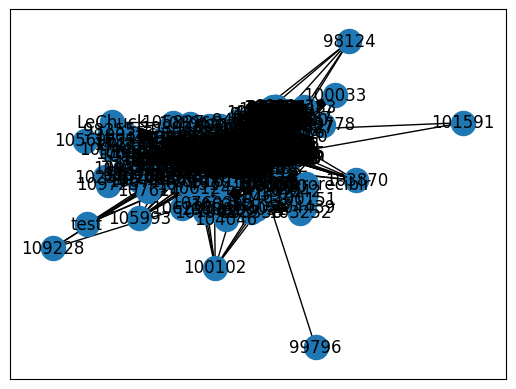

In [8]:
nx.draw_networkx(G)

In [9]:
print(G)
print(f"""
  El diámetro de la red: {nx.diameter(G)}
  El grado promedio de la red: {sum([n[1] for n in G.degree()]) / len(G):.2f}
  TODO: Los allegados promedio de la red: 
  Puentes globales: {list(nx.bridges(G))}
""")


MultiGraph with 407 nodes and 133155 edges

  El diámetro de la red: 4
  El grado promedio de la red: 654.32
  TODO: Los allegados promedio de la red: 
  Puentes globales: [('98439', '99796')]



In [10]:
from networkx.algorithms import community
louvain = community.louvain_communities(G)

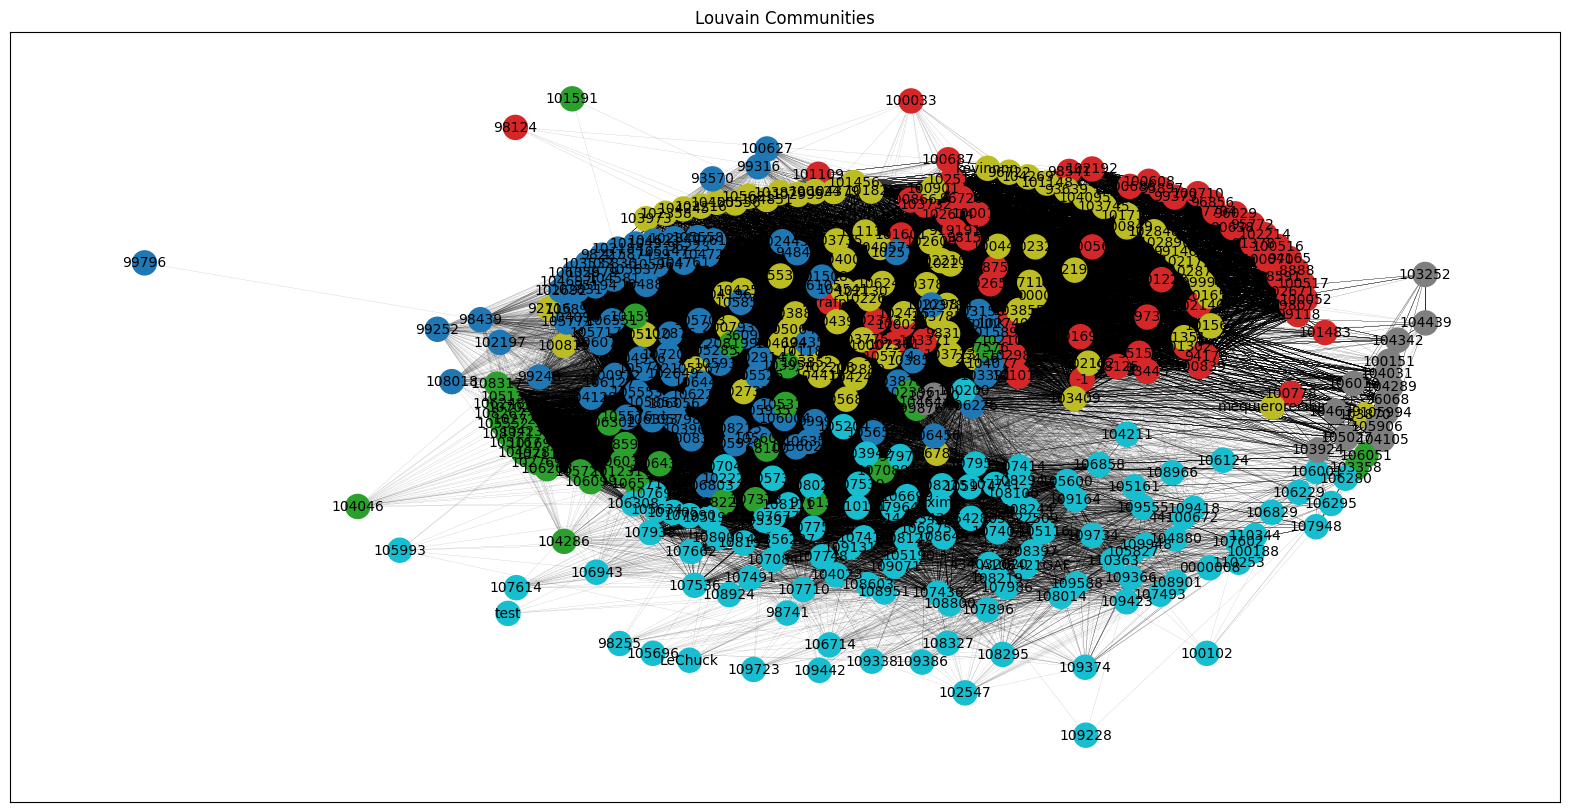

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

plt.figure(figsize=(20,10))

draw_nodes = {}
colors = random.sample(list(mcolors.TABLEAU_COLORS), len(louvain))
for louvaincommunity, color in zip(louvain, colors):
    draw_nodes.update({n: color for n in louvaincommunity})
    
plt.title("Louvain Communities")
nx.draw_networkx(G, 
                 nodelist=draw_nodes.keys(), 
                 node_color=list(draw_nodes.values()), 
                 width=0.05, 
                 pos=nx.kamada_kawai_layout(G),
                 font_size=10)

In [12]:
# Todo: sacar distribucion de padrones de cada comunidad, para poder clasificar
# as in "esta es la comunidad de los jovenes, esta es la de los viejos, esta no tiene patron, etc"
louvain

[{'-1',
  '100016',
  '100029',
  '100033',
  '100052',
  '100070',
  '100073',
  '100516',
  '100517',
  '100560',
  '100608',
  '100680',
  '100687',
  '100710',
  '100778',
  '100839',
  '100866',
  '101018',
  '101109',
  '101228',
  '101302',
  '101483',
  '101601',
  '101696',
  '102103',
  '102140',
  '102192',
  '102214',
  '102342',
  '102361',
  '102510',
  '102654',
  '102671',
  '102674',
  '102740',
  '102981',
  '103371',
  '103732',
  '8888',
  '90638',
  '91378',
  '919191',
  '93445',
  '94165',
  '94178',
  '95159',
  '95772',
  '95897',
  '96029',
  '96728',
  '96856',
  '97794',
  '98124',
  '98125',
  '98153',
  '98541',
  '98591',
  '98752',
  '99118',
  '99373',
  '99732',
  '99807',
  'fsrrafpp'},
 {'0000',
  '100445',
  '100624',
  '100815',
  '100849',
  '100901',
  '101148',
  '101187',
  '101456',
  '101562',
  '101651',
  '101715',
  '101826',
  '102102',
  '102130',
  '102179',
  '102208',
  '102210',
  '102216',
  '102219',
  '102264',
  '102323',
  '1023

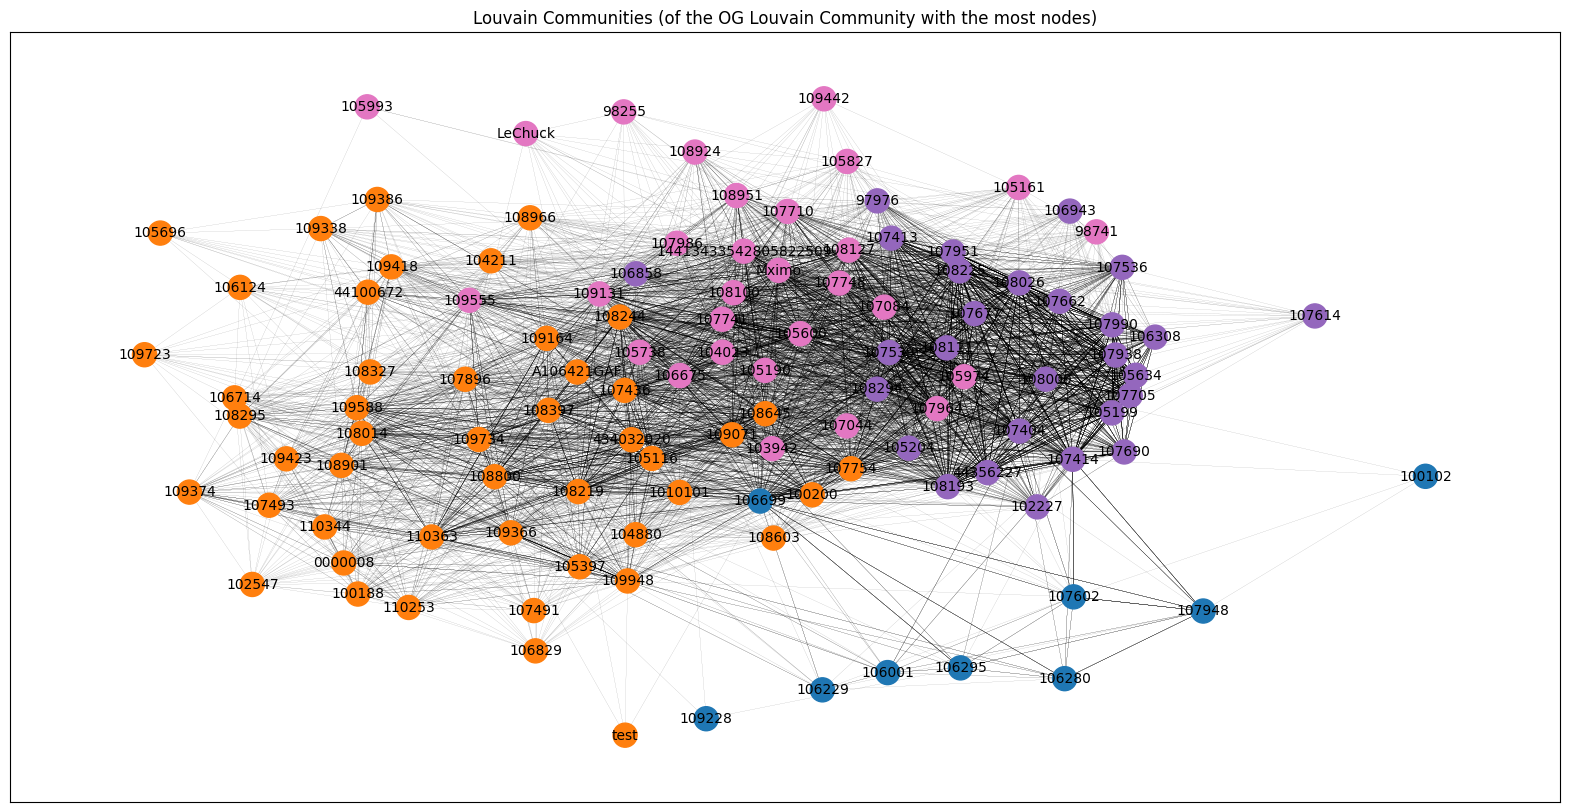

In [13]:
subnetwork = nx.subgraph(G, max(louvain, key=len))
subnetwork_louvain = community.louvain_communities(subnetwork)
plt.figure(figsize=(20,10))

draw_nodes = {}
colors = random.sample(list(mcolors.TABLEAU_COLORS), len(subnetwork_louvain))
for louvain, color in zip(subnetwork_louvain, colors):
    draw_nodes.update({n: color for n in louvain})
    
plt.title("Louvain Communities (of the OG Louvain Community with the most nodes)")
nx.draw_networkx(subnetwork, 
                 nodelist=draw_nodes.keys(), 
                 node_color=list(draw_nodes.values()), 
                 width=0.05, 
                 pos=nx.kamada_kawai_layout(subnetwork),
                 font_size=10)

In [14]:
subnetwork_louvain

[{'0000008',
  '100188',
  '100200',
  '1010101',
  '102547',
  '104211',
  '104880',
  '105116',
  '105397',
  '105696',
  '106124',
  '106714',
  '106829',
  '107436',
  '107491',
  '107493',
  '107754',
  '107896',
  '108014',
  '108219',
  '108244',
  '108295',
  '108327',
  '108397',
  '108603',
  '108645',
  '108800',
  '108901',
  '108966',
  '109071',
  '109164',
  '109338',
  '109366',
  '109374',
  '109386',
  '109418',
  '109423',
  '109588',
  '109723',
  '109734',
  '109948',
  '110253',
  '110344',
  '110363',
  '434032020',
  '44100672',
  'A106421GAF',
  'test'},
 {'103942',
  '104023',
  '105161',
  '105190',
  '105600',
  '105738',
  '105827',
  '105974',
  '105993',
  '106675',
  '107044',
  '107084',
  '107710',
  '107741',
  '107748',
  '107964',
  '107986',
  '108100',
  '108127',
  '108924',
  '108951',
  '109131',
  '109442',
  '109555',
  '14413433542805822509',
  '98255',
  '98741',
  'LeChuck',
  'Mximo'},
 {'102227',
  '105199',
  '105204',
  '105634',
  '10

In [15]:
# todo: usar graphrole y rolx

In [16]:
# todo: ejercicio 5 de parcialito 3

In [17]:
# todo: leer TODA la documentacion de "algorithms" de nx y ver que aplica aca
# https://networkx.org/documentation/stable/reference/algorithms/index.html

In [18]:
# todo: plantear preguntas y resolverlas con comunidades:
# "que electivas curso?"
# "que cuatrimestre armo?"